## Imports and libraries

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [65]:
data = pd.read_csv("all_countries_final_df.csv")
data.head()

,win,PPG_diff,GD_diff,Top_Scorers_diff,CS_diff
0,0,-1.166667,-21,0,-4
1,0,-1.500000,-24,0,-6
2,0,0.000000,-13,0,-5
3,1,0.560000,30,1,13
4,1,1.129492,100,3,27


## Descriptive statistics

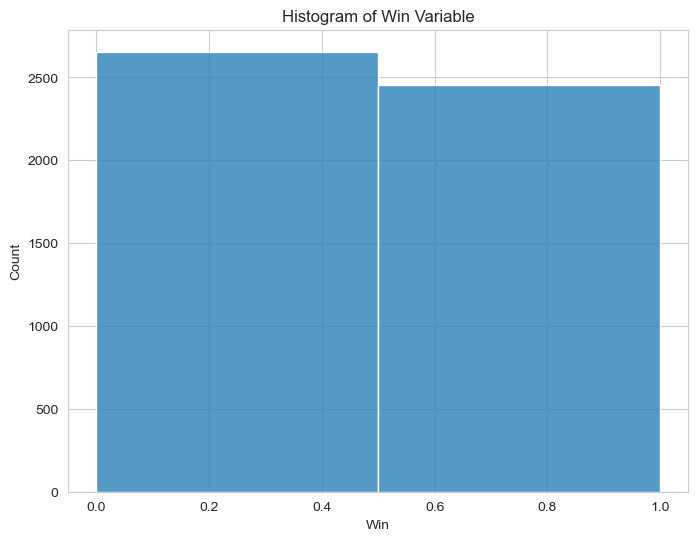

In [66]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histogram for the "win" variable
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x="win", bins=2, kde=False)
plt.title('Histogram of Win Variable')
plt.xlabel('Win')
plt.ylabel('Count')
plt.show()

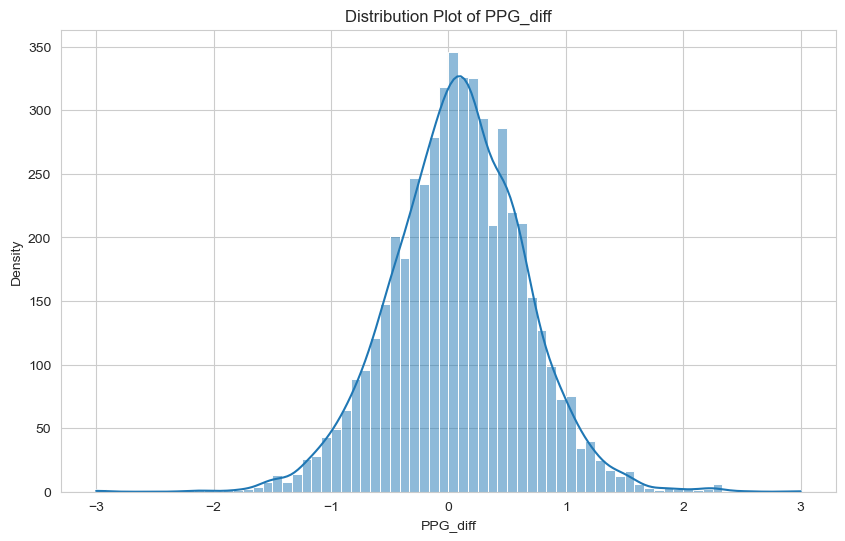

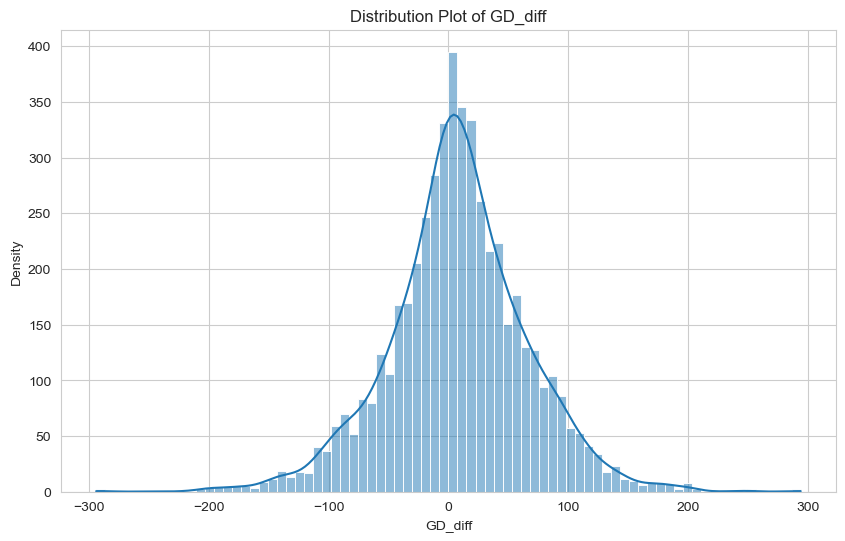

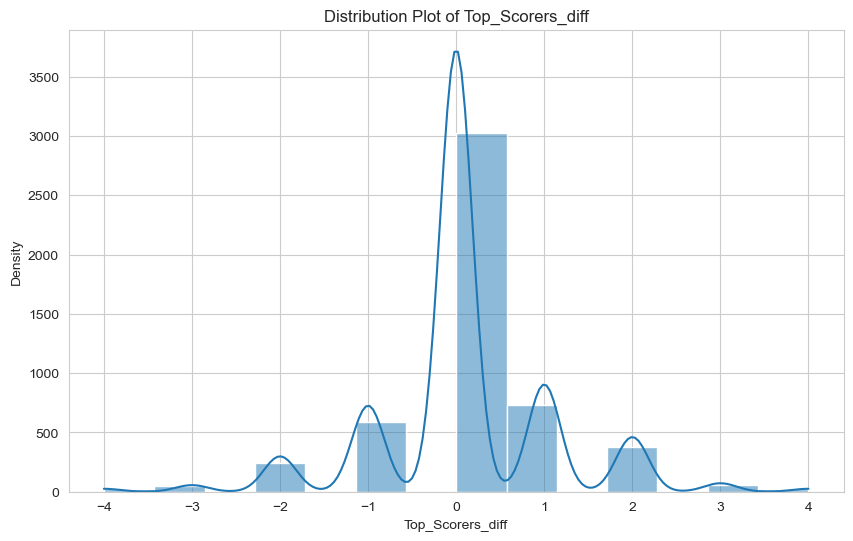

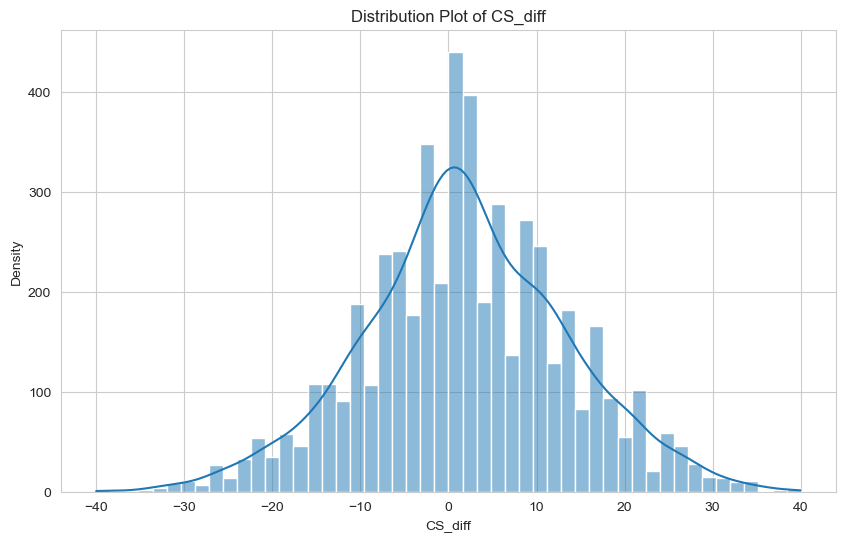

In [67]:
# Distribution plots for each of the other variables

# Define a list of variables to plot excluding 'win'
variables_to_plot = ['PPG_diff', 'GD_diff', 'Top_Scorers_diff', 'CS_diff']

# Create distribution plots
for variable in variables_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[variable], kde=True)
    plt.title(f'Distribution Plot of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.show()

In [69]:
# Function to detect outliers using IQR
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Applying the function to each variable
outlier_analysis = {}
for variable in variables_to_plot:
    outliers = detect_outliers(data, variable)
    outlier_analysis[variable] = {
        "lower_bound": outliers[variable].min(),
        "upper_bound": outliers[variable].max(),
        "num_outliers": outliers.shape[0],
        "outliers_indices": outliers.index.tolist()
    }

outlier_analysis


{'PPG_diff': {'lower_bound': -3.0,
  'upper_bound': 3.0,
  'num_outliers': 75,
  'outliers_indices': [1,
   99,
   159,
   175,
   359,
   416,
   423,
   429,
   434,
   508,
   512,
   534,
   538,
   539,
   624,
   795,
   862,
   864,
   865,
   1149,
   1206,
   1226,
   1395,
   1407,
   1584,
   1592,
   1600,
   1618,
   1714,
   1851,
   2058,
   2163,
   2194,
   2226,
   2227,
   2623,
   2626,
   2814,
   2865,
   2866,
   3099,
   3155,
   3420,
   3624,
   3665,
   3731,
   3787,
   3824,
   3825,
   3846,
   3891,
   3893,
   3896,
   3904,
   3906,
   3908,
   3910,
   3924,
   3972,
   4074,
   4187,
   4188,
   4194,
   4206,
   4361,
   4569,
   4570,
   4571,
   4607,
   4735,
   4740,
   4962,
   5028,
   5029,
   5046]},
 'GD_diff': {'lower_bound': -294,
  'upper_bound': 294,
  'num_outliers': 178,
  'outliers_indices': [21,
   76,
   85,
   99,
   159,
   175,
   285,
   388,
   406,
   414,
   416,
   417,
   423,
   426,
   429,
   434,
   440,
   441,
   512,

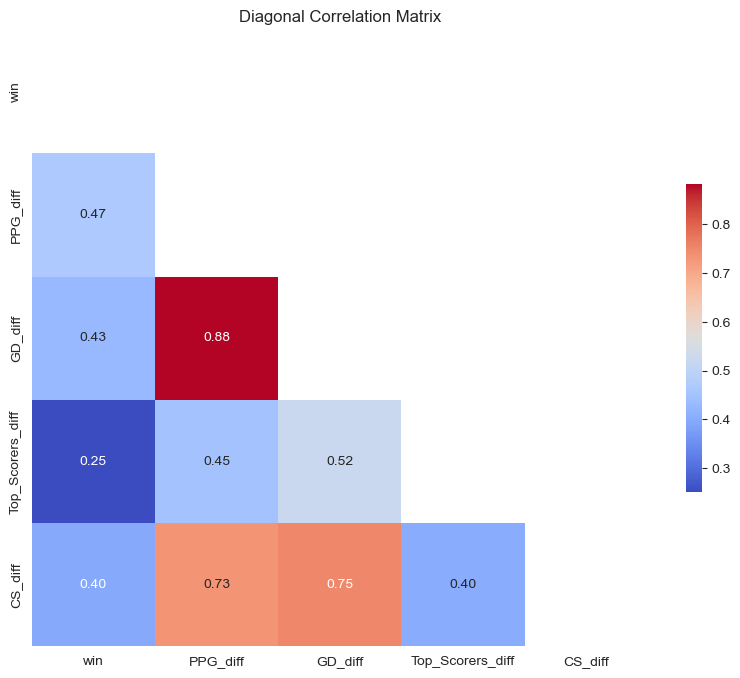

In [70]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

import numpy as np

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.title('Diagonal Correlation Matrix')
plt.show()



In [71]:
# Separate the features (X) and the target variable (y)
X = data.drop('win', axis=1)
y = data['win']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random_state works like set_seed

# Checking the size of the splits
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((4087, 4), (1022, 4), (4087,), (1022,))

## Functions for testing accuracy

In [72]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0.5, 1.5], classes)
    plt.yticks([0.5, 1.5], classes)
    plt.show()

In [73]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title='Receiver Operating Characteristic'):
    # Calculate ROC curve from y_test and y_test_pred_proba
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## Logistic regression model
win = PPG_diff + GD_diff + Top_Scorers_diff + CS_diff

In [74]:
# Instantiate the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logistic_model.fit(X_train, y_train)

# Predict on the training data
y_train_pred = logistic_model.predict(X_train)

# Calculate the accuracy on the training data
training_accuracy = accuracy_score(y_train, y_train_pred)

training_accuracy

0.7071201370198189

In [75]:
# Predict on the test data
y_test_pred = logistic_model.predict(X_test)
y_test_pred_proba = logistic_model.predict_proba(X_test)[:,1]

# Calculate the metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

test_accuracy

0.6643835616438356

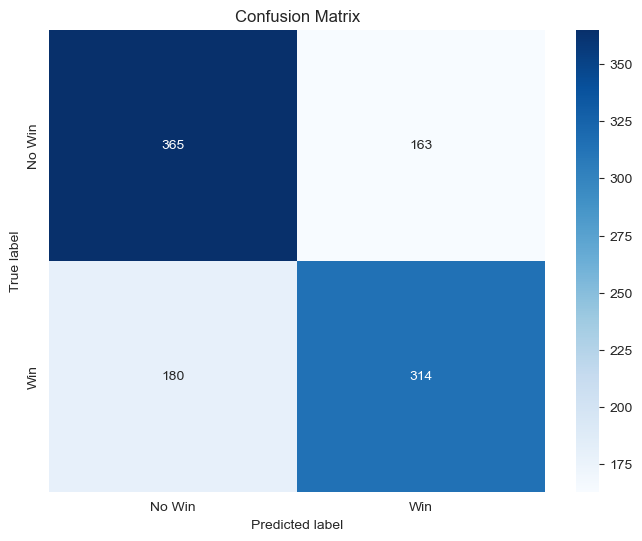

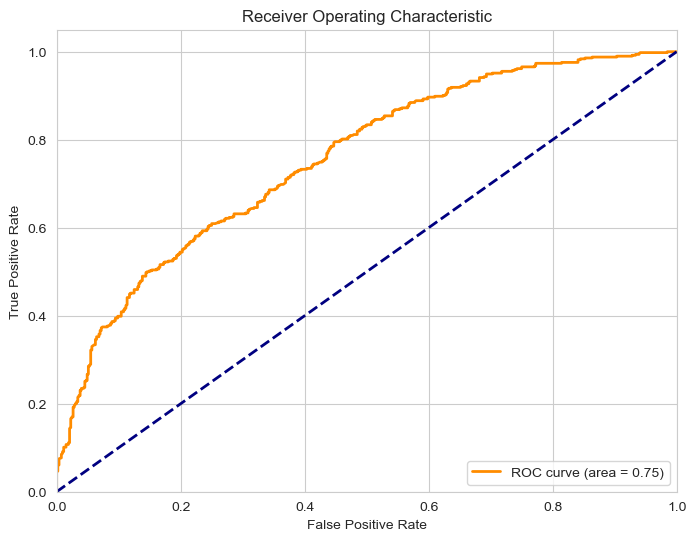

In [76]:
# Plotting the confusion matrix
plot_confusion_matrix(test_confusion_matrix, classes=['No Win', 'Win'])

# Plotting the ROC curve
plot_roc_curve(y_test, y_test_pred_proba)


## Decision trees

In [77]:
# Instantiate the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
decision_tree_model.fit(X_train, y_train)

# Predict on the test data
y_test_pred_dt = decision_tree_model.predict(X_test)
y_test_pred_proba_dt = decision_tree_model.predict_proba(X_test)[:, 1]

# Calculate the performance metrics
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
test_precision_dt = precision_score(y_test, y_test_pred_dt)
test_recall_dt = recall_score(y_test, y_test_pred_dt)
test_auc_dt = roc_auc_score(y_test, y_test_pred_proba_dt)
test_accuracy_dt

0.6203522504892368

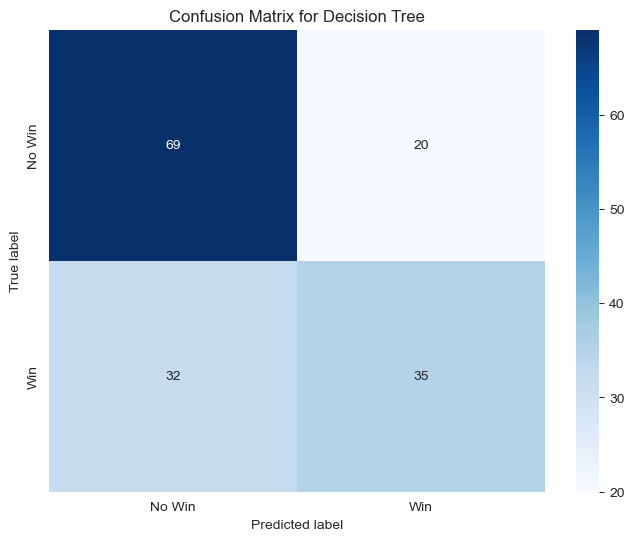

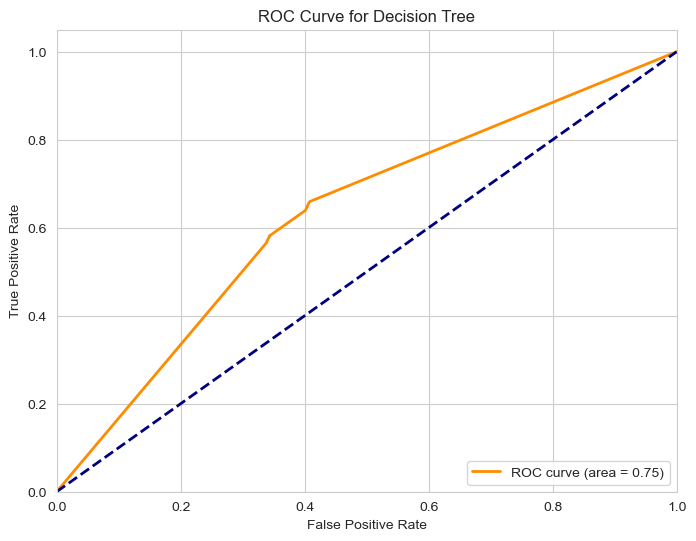

In [78]:
# Plotting the confusion matrix for the Decision Tree model
plot_confusion_matrix(test_confusion_matrix_dt, classes=['No Win', 'Win'], title='Confusion Matrix for Decision Tree')

# Plotting the ROC curve for the Decision Tree model
plot_roc_curve(y_test, y_test_pred_proba_dt, title='ROC Curve for Decision Tree')


## Random forest

In [79]:
# Instantiate the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
random_forest_model.fit(X_train, y_train)

# Predict on the test data
y_test_pred_rf = random_forest_model.predict(X_test)
y_test_pred_proba_rf = random_forest_model.predict_proba(X_test)[:, 1]

# Calculate the performance metrics
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_precision_rf = precision_score(y_test, y_test_pred_rf)
test_recall_rf = recall_score(y_test, y_test_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
test_confusion_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)

test_accuracy_rf

0.6213307240704501

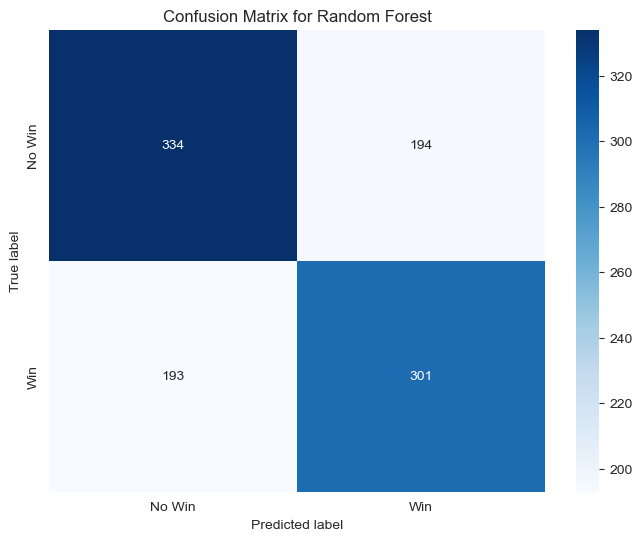

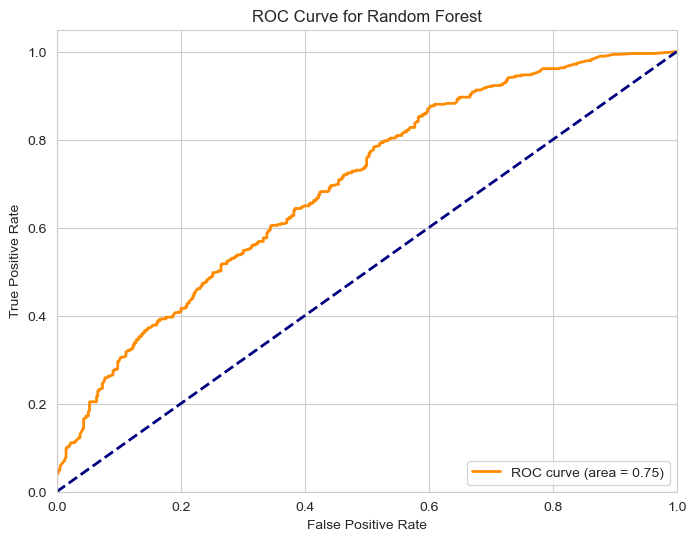

In [80]:
# Plotting the confusion matrix for the Random Forest model
plot_confusion_matrix(test_confusion_matrix_rf, classes=['No Win', 'Win'], title='Confusion Matrix for Random Forest')

# Plotting the ROC curve for the Random Forest model
plot_roc_curve(y_test, y_test_pred_proba_rf, title='ROC Curve for Random Forest')

## KNN

In [81]:
# Standardizing the feature variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the KNN model (we'll start with k=5)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_test_pred_knn = knn_model.predict(X_test_scaled)
y_test_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the performance metrics
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
test_precision_knn = precision_score(y_test, y_test_pred_knn)
test_recall_knn = recall_score(y_test, y_test_pred_knn)
test_auc_knn = roc_auc_score(y_test, y_test_pred_proba_knn)
test_confusion_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)

test_accuracy_knn

/Users/andre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6320939334637965

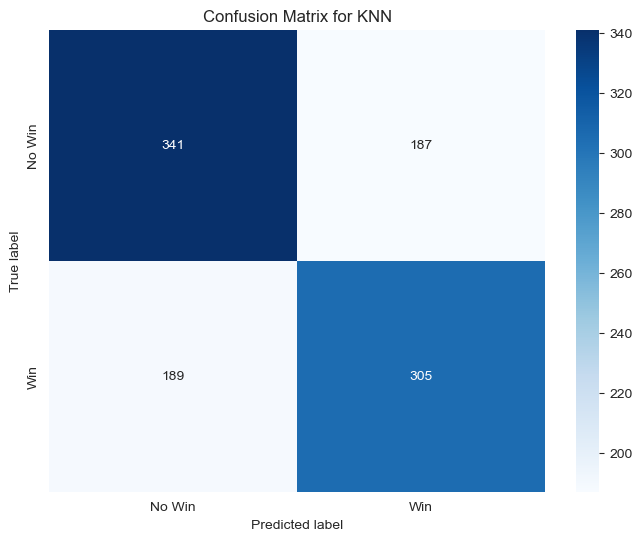

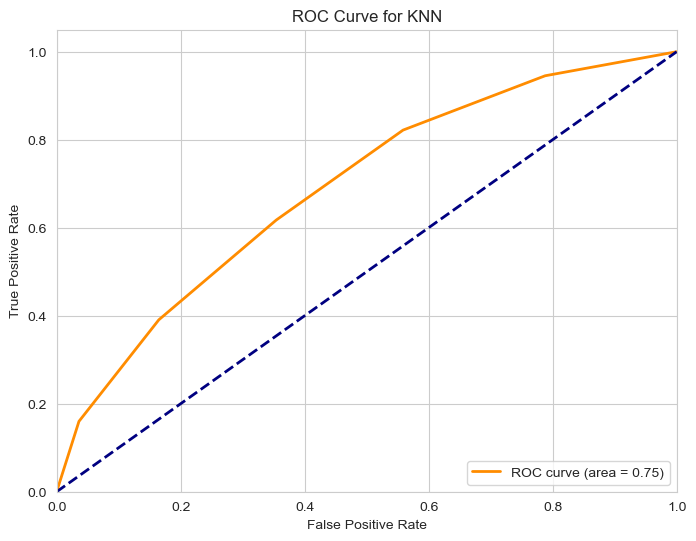

In [82]:
# Plotting the confusion matrix for the KNN model
plot_confusion_matrix(test_confusion_matrix_knn, classes=['No Win', 'Win'], title='Confusion Matrix for KNN')

# Plotting the ROC curve for the KNN model
plot_roc_curve(y_test, y_test_pred_proba_knn, title='ROC Curve for KNN')

## Model Choice
Given our test accuracy scores, we wil proceed with the Logistic Regression Model

In [83]:
# Importing the required library for table creation
import pandas as pd

# Accuracy scores from previous models (test set scores)
accuracy_scores = {
    'Logistic Regression': test_accuracy,  # This is the training accuracy for Logistic Regression
    'Decision Tree': test_accuracy_dt,
    'Random Forest': test_accuracy_rf,
    'KNN': test_accuracy_knn
}

# Convert the dictionary to a DataFrame for a nicer table display
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy'])

accuracy_df


,Model,Accuracy
0,Logistic Regression,0.664384
1,Decision Tree,0.620352
2,Random Forest,0.621331
3,KNN,0.632094


## Improve accuracy

In [84]:
# Outliers indices found previously for PPG_diff and GD_diff
outliers_indices = set(outlier_analysis['PPG_diff']['outliers_indices'] + outlier_analysis['GD_diff']['outliers_indices'])

# Drop the rows that are outliers in either PPG_diff or GD_diff
data_no_outliers = data.drop(index=outliers_indices)

# Split the data_no_outliers into features (X) and target (y) variables
X_no_outliers = data_no_outliers.drop('win', axis=1)
y_no_outliers = data_no_outliers['win']

# Split the data into training and test sets (80% train, 20% test)
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Instantiate the Logistic Regression model
logistic_model_no_outliers = LogisticRegression(max_iter=1000)

# Fit the model to the training data without outliers
logistic_model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

# Predict on the test data
y_test_pred_no_outliers = logistic_model_no_outliers.predict(X_test_no_outliers)

# Calculate the accuracy on the test data without outliers
test_accuracy_no_outliers = accuracy_score(y_test_no_outliers, y_test_pred_no_outliers)

test_accuracy_no_outliers


0.6683673469387755

#### Regularization

In [87]:
# Regularization strength values (C) to try
# We use the inverse of the values because in scikit-learn, C is the inverse of regularization strength
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Instantiate the Logistic Regression model with cross-validation to find the optimal C value
# cv=5 indicates a 5-fold cross-validation
logistic_model_cv_l2 = LogisticRegressionCV(Cs=C_values, cv=5, penalty='l2', max_iter=1000, random_state=42).fit(X_train_no_outliers, y_train_no_outliers)

# The best C value found
best_C_l2 = logistic_model_cv_l2.C_[0]

# Train a new model with the best C value
logistic_model_l2 = LogisticRegression(C=best_C_l2, penalty='l2', max_iter=1000)
logistic_model_l2.fit(X_train_no_outliers, y_train_no_outliers)

# Predict on the test data
y_test_pred_l2 = logistic_model_l2.predict(X_test_no_outliers)

# Calculate the accuracy on the test data
test_accuracy_l2 = accuracy_score(y_test_no_outliers, y_test_pred_l2)

best_C_l2, test_accuracy_l2


(10.0, 0.6704081632653062)